# Creando la primera red convolucional - Callbacks: early stopping y checkpoints


In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
import os
import sys

sys.path.append(os.path.dirname(os.path.abspath(os.path.abspath(""))))

In [5]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.datasets import fashion_mnist
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.losses import SparseCategoricalCrossentropy
from keras.utils import to_categorical

Nuestro trabajo de esta sección consiste en resolver un problema de clasificación multiple. Poder clasificar entre 10 tipos de prenda de vestir. Para ello vamos a utilizar el dataset [Fashion MNIST](https://keras.io/api/datasets/fashion_mnist/)

El cual cuenta con 60,000 imágenes de 28x28 píxeles en escala de grises. Adicionalmente, cuenta con un set de prueba de 10,000 imágenes con las mismas características que el set de entrenamiento.

Las clases disponibles son:

| Label |   Description   |
| :---: | :-------------: |
|   0   | **T-shirt/top** |
|   1   |   **Trouser**   |
|   2   |  **Pullover**   |
|   3   |    **Dress**    |
|   4   |    **Coat**     |
|   5   |   **Sandal**    |
|   6   |    **Shirt**    |
|   7   |   **Sneaker**   |
|   8   |     **Bag**     |
|   9   | **Ankle boot**  |


In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
# 60_000 imagenes de 28x28 pixeles
print(
    f"{train_images.shape[0]} imagenes de {train_images.shape[1]}x{train_images.shape[2]} pixeles"
)
# train_images.shape

60000 imagenes de 28x28 pixeles


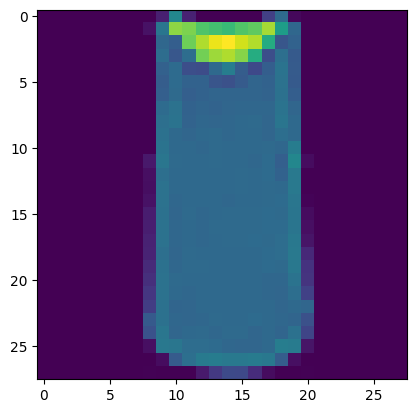

In [6]:
plt.imshow(train_images[2])
plt.show()

Normalizando datos


In [7]:
# Normalizando datos
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

A diferencia de las redes neuronales normales, dónde la entrada debía ser un vector de 1 dim
en las CNN la entrada es una matriz, es por eso que en el reshape debemos tomar en cuenta
[[]].reshape(n, x, y, c)

n, x, y, c ->
n = número de imágenes,
x = ancho de la imagen,
y = largo de la imagen,
c = número de canales.

Dado que nuestras imágenes están en escala de grises, entonces el número de canales que maneja es 1.


In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

Transformando números del 0 al 9 (10 clases) en su One Hot Encoding


In [9]:
train_labels_categorical = to_categorical(train_labels, 10)
test_labels_categorical = to_categorical(test_labels, 10)

**NOTA:** Cabe destacar que por ser una CNN NO fue necesario usar un vector 1d para esta arquitectura.


Definimos la arquictecura


In [10]:
def architecture(model_: Sequential):
    model_.add(
        Conv2D(
            filters=64,
            kernel_size=2,
            padding="same",
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model_.add(MaxPool2D(pool_size=2))
    # Reduce el overfitting
    model_.add(Dropout(0.30))
    # Apilar capas
    model_.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
    model_.add(MaxPool2D(pool_size=2))
    model_.add(Dropout(0.30))
    # Esta capa sirve para aplanar y pasar de redes convolucionales a normales
    model_.add(Flatten())
    model_.add(Dense(256, activation="relu"))
    model_.add(Dropout(0.5))
    # Como es un problema de clasificación multilabel usamos softmax como activacion de la lutima capa
    model_.add(Dense(10, activation="softmax"))
    print(model_.summary())
    # Compilacion del modelo con la informacio
    model_.compile(
        loss="categorical_crossentropy", optimizer="rmsprop", metrics="accuracy"
    )
    return model_

## Entrenando nuestra primera red convolucional


In [11]:
def plot_results(history_, metric):
    history_dict = history_.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    metric_values = history_dict[metric]
    val_metric_values = history_dict[f"val_{metric}"]
    epoch = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    fig.suptitle("Neural Network's Result")
    ax[0].set_title("Loss function over epochs")
    ax[1].set_title(f"{metric} over epoch")
    ax[0].set(ylabel="loss", xlabel="epoch")
    ax[1].set(ylabel=metric, xlabel="epoch")

    ax[0].plot(epoch, loss_values, "o-r", label="training")
    ax[0].plot(epoch, val_loss_values, "--", label="validation")
    ax[1].plot(epoch, metric_values, "o-r", label="training")
    ax[1].plot(epoch, val_metric_values, "--", label="validation")
    ax[0].legend()
    ax[1].legend()
    plt.show()

## Entrenando el modelo


In [12]:
model = Sequential()
model = architecture(model)
history = model.fit(
    train_images,
    train_labels_categorical,
    batch_size=64,
    epochs=10,
    validation_split=0.3,
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)          

## Análisis de resultados


In [13]:
score = model.evaluate(test_images, test_labels_categorical)
print(score)

313/313 [==============================] - 1s 2ms/step - loss: 0.2813 - accuracy: 0.8962
[0.2812596261501312, 0.8962000012397766]


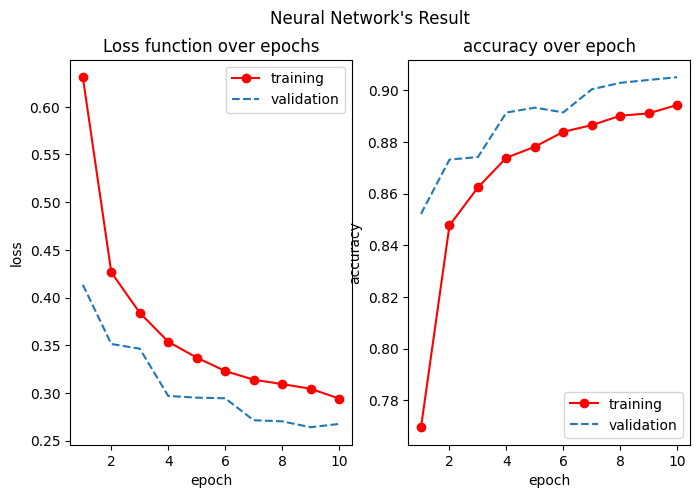

In [14]:
plot_results(history, "accuracy")

## BONUS: Una forma alternativa de resolución del problema.

Para esta forma alternativa, vamos a modificar la arquitectura del modelo levemente, en esta ocasión vamos a utilizar como función de perdida SparseCategoricalCrossentropy está nos va a permitir trabajar directamente con los valores originales de los labels, train_labels, test_labels sin necesidad de pasarlos por la función to_categorical adicionalmente, nos permitirá NO usar la función softmax que hemos utilizado siempre en problemas de clasificación multiple.


Nueva arquitectura:


In [15]:
def architecture_sparse(model_: Sequential):

    model_.add(
        Conv2D(
            filters=64,
            kernel_size=2,
            padding="same",
            activation="relu",
            input_shape=(28, 28, 1),
        )
    )
    model_.add(MaxPool2D(pool_size=2))
    model_.add(Dropout(0.3))
    model_.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
    model_.add(MaxPool2D(pool_size=2))
    model_.add(Dropout(0.3))
    model_.add(Flatten())
    model_.add(Dense(256, activation="relu"))
    model_.add(Dropout(0.5))
    # Utilizando como perdida la SparceCategoricalCrossentropy
    model_.add(Dense(10))
    print(model_.summary())
    model_.compile(
        loss=SparseCategoricalCrossentropy(from_logits=True),
        optimizer="rmsprop",
        metrics="accuracy",
    )
    return model_

Entrenamos nuestro nuevo modelo:


In [16]:
model_sparse = Sequential()
model_sparse = architecture_sparse(model_sparse)
# Este tipo de modelo NO exige usar las encadenadas de capas como categoricas, por eso puedo usar las train_labels normal.
history = model_sparse.fit(
    train_images, train_labels, batch_size=64, epochs=10, validation_split=0.3
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)         

In [17]:
score_sparse = model_sparse.evaluate(test_images, test_labels)
print(score_sparse)

313/313 [==============================] - 1s 2ms/step - loss: 0.2862 - accuracy: 0.8949
[0.2861770689487457, 0.8949000239372253]


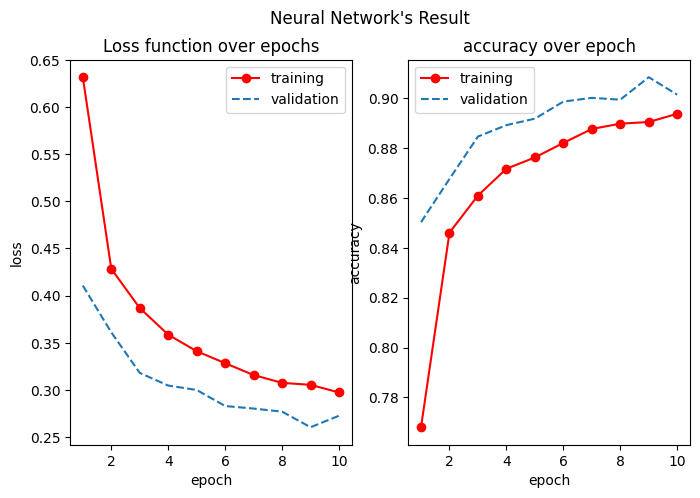

In [18]:
plot_results(history, "accuracy")

# Callbacks: early stopping y checkpoints

Los `Callbacks` son una herramienta sumamente poderosa que nos permite monitorear el entrenamiento de nuestras redes neuronales tienen varias funcionalidades, sin embargo, en este ejemplo hablaremos de 2 de las más utilizadas:

1. Early stopping: Detener el proceso de entrenamiento cuando este deja de optimizar.

2. Checkpoints: Permite guardar el estado de un modelo mientras está siendo entrenado.


## 1: Empecemos por importar las bibliotecas que ya conocemos

Sin embargo, aquí vamos a añadir un par de nuevas bibliotecas que nos permitirán usar callbacks y cargar modelos guardados.


In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

## 2. Creando arquitectura del modelo


In [8]:
def architecture_callback(shape, name):
    model_ = Sequential(name=name)
    model_.add(
        Conv2D(
            filters=64,
            kernel_size=2,
            padding="same",
            activation="relu",
            input_shape=shape,
        )
    )
    model_.add(MaxPool2D(pool_size=2))
    model_.add(Dropout(0.3))
    model_.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
    model_.add(MaxPool2D(pool_size=2))
    model_.add(Dropout(0.3))
    model_.add(Flatten())
    model_.add(Dense(256, activation="relu"))
    model_.add(Dropout(0.5))
    model_.add(Dense(10, activation="softmax"))
    print(model_.summary())
    return model_

## 3. Descargando el dataset y normalizando datos


In [9]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

train_labels_categorical = to_categorical(train_labels, 10)
test_labels_categorical = to_categorical(test_labels, 10)

## 4: Creando Callbacks

Esta es la parte interesante de esta nueva sección, vamos a crear `Callbacks` para monitorear el entrenamiento de nuestra red.

### Early Stopping

Empecemos por definir un callback de `Early Stopping` Te aconsejo leer toda la documentación para entender mejor su uso.


In [10]:
# Callbacks de EarlyStopping

early_stopping_cb = EarlyStopping(monitor="val_accuracy", patience=1, verbose=1)

# Creaando arquitecura del modelo

model_c = architecture_callback(shape=train_images[0].shape, name="Early_Stopping")

# Compilando el modelo

model_c.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics="accuracy"
)



Model: "Early_Stopping"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 32)     

In [11]:
model_c.fit(
    train_images,
    train_labels_categorical,
    batch_size=256,
    epochs=15,
    validation_split=0.3,
    callbacks=[early_stopping_cb],
)

Epoch 1/15


165/165 [==============================] - 8s 42ms/step - loss: 0.8485 - accuracy: 0.6863 - val_loss: 0.5906 - val_accuracy: 0.7656
Epoch 2/15
165/165 [==============================] - 7s 41ms/step - loss: 0.5185 - accuracy: 0.8098 - val_loss: 0.4161 - val_accuracy: 0.8476
Epoch 3/15
165/165 [==============================] - 7s 41ms/step - loss: 0.4534 - accuracy: 0.8356 - val_loss: 0.3786 - val_accuracy: 0.8641
Epoch 4/15
165/165 [==============================] - 7s 43ms/step - loss: 0.4141 - accuracy: 0.8491 - val_loss: 0.3509 - val_accuracy: 0.8726
Epoch 5/15
165/165 [==============================] - 7s 42ms/step - loss: 0.3884 - accuracy: 0.8588 - val_loss: 0.3441 - val_accuracy: 0.8738
Epoch 6/15
165/165 [==============================] - 7s 43ms/step - loss: 0.3636 - accuracy: 0.8675 - val_loss: 0.3307 - val_accuracy: 0.8811
Epoch 7/15
165/165 [==============================] - 7s 42ms/step - loss: 0.3500 - accuracy: 0.8715 - val_loss: 0.3294 - val_accuracy: 0.87

In [12]:
score_c = model_c.evaluate(test_images, test_labels_categorical)
print(score_c)

313/313 [==============================] - 1s 2ms/step - loss: 0.3432 - accuracy: 0.8725
[0.34324949979782104, 0.8725000023841858]


En este momento hemos definido un callback de early stopping, para efectos demostrativos estamos monitoreando el valor de accuracy NO del dataset de entrenamiento sino del de validación. En otras palabras, le estamos pidiendo al modelo que se detenga cuando NO haya logrado optimizar el accuracy del dataset de validación, tomando como restricción 1 única epoch. Esto es sumamente restrictivo, aquí solo está hecho para poder ejemplificar el caso, sin embargo, la `patience` debería ser mayor a 1 para evitar el ruido.


Podemos ver que inmediatamente que él `val_accuracy` cayó el modelo dejo de ser entrenado. Esto en medida se debe al valor de `batch_size` que elegimos, un valor más pequeño es más lento de entrenar, aumenta en menor velocidad el accuracy, pero suele ser más estable. De cualquier forma, aquí SOLO buscabamos demostrar el comportamiento de `early stopping` no optimizar la red.


## Checkpoint

Este es un callback de extremada utilidad, pues permite ir guardando en cada epoch o n epoch el modelo que mejor optimice una feature. Te aconsejo ampliamente leer [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/).


Creamos nuestro callback de checkpoint, le decimos que vamos a guardar el modelo entero (incluyendo, arquitecura, pesos etc) vamos a monitorear el `accuracy` del modelo, vamos a guardar el mejor modelo que encontremos y el modelo será guardado en `models/best_model.h5`


In [13]:
# Callbacks de ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath="../model/best_model.h5",
    save_weights_only=False,
    monitor="accuracy",
    mode="max",
    save_best_only=True,
    verbose=1,
)

# Creando arquitectura del modelo
model_c_c = architecture_callback(shape=train_images[0].shape, name="Checkpoint")

# Compilando el modelo
model_c_c.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics="accuracy"
)

Model: "Checkpoint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 32)          0

In [15]:
model_c_c.fit(
    train_images,
    train_labels_categorical,
    batch_size=64,
    epochs=15,
    validation_split=0.3,
    callbacks=[checkpoint_cb],
)

Epoch 1/15
656/657 [============================>.] - ETA: 0s - loss: 0.4947 - accuracy: 0.8209
Epoch 1: accuracy improved from -inf to 0.82090, saving model to ../model\best_model.h5
657/657 [==============================] - 8s 12ms/step - loss: 0.4947 - accuracy: 0.8209 - val_loss: 0.3898 - val_accuracy: 0.8578
Epoch 2/15
 16/657 [..............................] - ETA: 7s - loss: 0.4044 - accuracy: 0.8594

c:\Users\mike\Desktop\redes_convolucionales\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


653/657 [============================>.] - ETA: 0s - loss: 0.4089 - accuracy: 0.8531
Epoch 2: accuracy improved from 0.82090 to 0.85317, saving model to ../model\best_model.h5
657/657 [==============================] - 8s 12ms/step - loss: 0.4090 - accuracy: 0.8532 - val_loss: 0.3663 - val_accuracy: 0.8644
Epoch 3/15
656/657 [============================>.] - ETA: 0s - loss: 0.3666 - accuracy: 0.8677
Epoch 3: accuracy improved from 0.85317 to 0.86776, saving model to ../model\best_model.h5
657/657 [==============================] - 8s 12ms/step - loss: 0.3665 - accuracy: 0.8678 - val_loss: 0.3056 - val_accuracy: 0.8905
Epoch 4/15
656/657 [============================>.] - ETA: 0s - loss: 0.3447 - accuracy: 0.8751
Epoch 4: accuracy improved from 0.86776 to 0.87502, saving model to ../model\best_model.h5
657/657 [==============================] - 8s 12ms/step - loss: 0.3448 - accuracy: 0.8750 - val_loss: 0.3114 - val_accuracy: 0.8833
Epoch 5/15
652/657 [============================>.] - 

Ahora veamos los resultados con el dataset de prueba:


In [17]:
# Podemos asegurarnos de que el modelo se ha guardado correctamente cargandolo y evaluandolo

loaded_model = load_model("../model/best_model.h5")

print("Model: ", model_c_c.evaluate(test_images, test_labels_categorical))

print("Model Checkpoint: ", loaded_model.evaluate(test_images, test_labels_categorical))

313/313 [==============================] - 1s 2ms/step - loss: 0.2729 - accuracy: 0.9054
Model:  [0.2728510797023773, 0.9053999781608582]
313/313 [==============================] - 1s 2ms/step - loss: 0.2729 - accuracy: 0.9054
Model Checkpoint:  [0.2728510797023773, 0.9053999781608582]
